In [1]:
import pandas as pd
from sqlalchemy import create_engine, text

In [2]:
mysql_user = "user"
mysql_password = "password"
mysql_host = "127.0.0.1"
mysql_port = "3306"
mysql_db = "testdb"

### Conexión a la base de datos

In [3]:
engine = create_engine(f"mysql+mysqlconnector://{mysql_user}:{mysql_password}@{mysql_host}:{mysql_port}/{mysql_db}")

In [4]:
df = pd.read_csv("../data/netflix_titles.csv")

In [5]:
tabla_nombre = "Netflix"

In [7]:
df.to_sql(name=tabla_nombre, con=engine, if_exists='replace', index=False)

print(f"Datos cargados en la tabla '{tabla_nombre}' correctamente.")

Datos cargados en la tabla 'Netflix' correctamente.


### Consultas básicas SQL

Número de filas cargadas: 8807
('s1', 'Movie', 'Dick Johnson Is Dead', 'Kirsten Johnson', None, 'United States', 'September 25, 2021', 2020, 'PG-13', '90 min', 'Documentaries', 'As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.')
('s2', 'TV Show', 'Blood & Water', None, 'Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mah ... (5 characters truncated) ... , Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng', 'South Africa', 'September 24, 2021', 2021, 'TV-MA', '2 Seasons', 'International TV Shows, TV Dramas, TV Mysteries', 'After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.')
('s3', 'TV Show', 'Gan

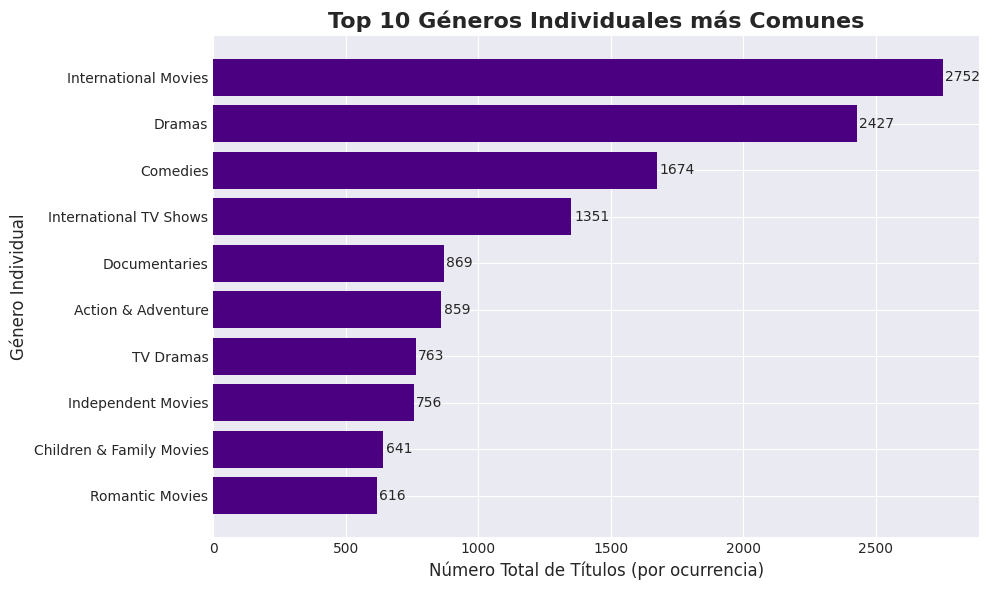

In [9]:
import matplotlib.pyplot as plt
with engine.connect() as conn:
    # Contar filas
    result = conn.execute(text(f"SELECT COUNT(*) FROM {tabla_nombre};"))
    count = result.scalar()
    print(f"Número de filas cargadas: {count}")

    # Mostrar las 5 primeras filas
    result = conn.execute(text(f"SELECT * FROM {tabla_nombre} LIMIT 5;"))
    for row in result:
        print(row)
    
    # Series y Pelis de España
    pais = "Spain"
    result = conn.execute(text(f"""
                SELECT title, country
                FROM {tabla_nombre}
                WHERE country = :pais
                LIMIT 10;"""), {"pais": pais})
    for row in result:
        print(row)
    
    
    # Géneros más comunes
    query_todos_generos = text(f"""
             SELECT listed_in
             FROM {tabla_nombre};
        """)
    
    # Ejecutar la consulta y cargar TODOS los géneros en un DataFrame
    result = conn.execute(query_todos_generos)
    df_raw_generos = pd.DataFrame(result.fetchall(), columns=result.keys())
    

    df_split = df_raw_generos['listed_in'].str.split(', ', expand=True).stack()
    df_split = df_split.str.strip()
    
    conteo_generos = df_split.value_counts().head(10)
    
    df_generos_individuales = conteo_generos.reset_index()
    df_generos_individuales.columns = ['genero', 'total']
    
    print ("\n Top 10 Géneros Individuales más comunes son: ")
    print(df_generos_individuales)
    
    
    plt.style.use('seaborn-v0_8-darkgrid')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df_generos_individuales['genero'], df_generos_individuales['total'], color='indigo')
    
    ax.set_title('Top 10 Géneros Individuales más Comunes', fontsize=16, fontweight='bold')
    ax.set_xlabel('Número Total de Títulos (por ocurrencia)', fontsize=12)
    ax.set_ylabel('Género Individual', fontsize=12)
    
    ax.invert_yaxis() 
    for i, (total, genero) in enumerate(zip(df_generos_individuales['total'], df_generos_individuales['genero'])):
    
        ax.text(total + 10, i, str(total), va='center')
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
    